In [1]:
#Install Required Packages
!pip install transformers[torch]
!pip install datasets
!pip install torch torchvision torchaudio
!pip install opencv-python
!pip install scikit-learn
!pip install matplotlib seaborn
!pip install tqdm
!pip install kaggle
!pip install accelerate
!pip install av

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
#Import Libraries
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import VivitImageProcessor, VivitForVideoClassification, VivitConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import random
from pathlib import Path
import warnings
import kagglehub
warnings.filterwarnings('ignore')

In [3]:
#Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [4]:
# Download the dataset
data_path = kagglehub.dataset_download("reubensuju/celeb-df-v2")

100%|██████████| 9.29G/9.29G [07:32<00:00, 22.0MB/s]

Extracting files...


In [5]:
# Set paths
real_videos_path = os.path.join(data_path, "Celeb-real")
fake_videos_path = os.path.join(data_path, "Celeb-synthesis")

# Check if paths exist
print(f"Real videos path exists: {os.path.exists(real_videos_path)}")
print(f"Fake videos path exists: {os.path.exists(fake_videos_path)}")

Real videos path exists: True
Fake videos path exists: True


In [6]:
# List directory contents
for root, dirs, files in os.walk(data_path):
    level = root.replace(data_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files) - 5} more files")

1/
  List_of_testing_videos.txt
  YouTube-real/
    00080.mp4
    00205.mp4
    00157.mp4
    00031.mp4
    00139.mp4
    ... and 295 more files
  Celeb-real/
    id0_0007.mp4
    id61_0003.mp4
    id0_0009.mp4
    id58_0000.mp4
    id46_0003.mp4
    ... and 585 more files
  Celeb-synthesis/
    id19_id20_0000.mp4
    id45_id42_0008.mp4
    id23_id9_0001.mp4
    id11_id7_0008.mp4
    id16_id0_0003.mp4
    ... and 5634 more files


In [7]:
# Video Processing
def extract_frames_from_video(video_path, num_frames=32, target_size=(224, 224)):

    cap = cv2.VideoCapture(video_path)
    frames = []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames < num_frames:
        # If video has fewer frames than needed, duplicate frames
        frame_indices = []
        for i in range(num_frames):
            frame_indices.append(min(i, total_frames - 1))
    else:
        # Sample frames uniformly
        frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)

    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()

        if ret:
            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Resize frame to exact target size
            frame = cv2.resize(frame, target_size, interpolation=cv2.INTER_LINEAR)
            frames.append(frame)
        else:
            # Create black frame if reading fails
            frames.append(np.zeros((*target_size, 3), dtype=np.uint8))

    cap.release()

    # Ensure we have exactly num_frames
    frames = frames[:num_frames]  # Truncate if too many
    while len(frames) < num_frames:
        if frames:
            frames.append(frames[-1])  # Duplicate last frame
        else:
            frames.append(np.zeros((*target_size, 3), dtype=np.uint8))

    return np.array(frames)

def get_video_files(directory):
    """
    Get all video files from directory
    """
    video_extensions = ['.mp4', '.avi', '.mov', '.mkv', '.flv', '.wmv']
    video_files = []

    for ext in video_extensions:
        video_files.extend(Path(directory).glob(f"**/*{ext}"))

    return [str(f) for f in video_files]

In [8]:
# Create Dataset Class
class DeepFakeDataset(Dataset):
    def __init__(self, video_paths, labels, processor, num_frames=32):
        self.video_paths = video_paths
        self.labels = labels
        self.processor = processor
        self.num_frames = num_frames

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        try:
            # Extract frames from video
            frames = extract_frames_from_video(video_path, self.num_frames, target_size=(224, 224))

            # Convert to list for processor
            frames_list = [frames[i] for i in range(len(frames))]

            # Process frames using ViViT processor
            inputs = self.processor(frames_list, return_tensors="pt", do_resize=False)

            # Get pixel values and ensure correct shape
            pixel_values = inputs['pixel_values'].squeeze(0)  # Remove batch dimension

            return {
                'pixel_values': pixel_values,
                'labels': torch.tensor(label, dtype=torch.long)
            }
        except Exception as e:
            print(f"Error processing video {video_path}: {str(e)}")
            # Return dummy data in case of error
            dummy_frames = [np.zeros((224, 224, 3), dtype=np.uint8) for _ in range(self.num_frames)]
            inputs = self.processor(dummy_frames, return_tensors="pt", do_resize=False)
            pixel_values = inputs['pixel_values'].squeeze(0)

            return {
                'pixel_values': pixel_values,
                'labels': torch.tensor(label, dtype=torch.long)
            }

            return {
                'pixel_values': pixel_values,
                'labels': torch.tensor(label, dtype=torch.long)
            }


In [9]:
# Prepare Data

# Get video files
print("Collecting video files...")
real_videos = get_video_files(real_videos_path)
fake_videos = get_video_files(fake_videos_path)

print(f"Found {len(real_videos)} real videos")
print(f"Found {len(fake_videos)} fake videos")

# Create labels (0 for real, 1 for fake)
real_labels = [0] * len(real_videos)
fake_labels = [1] * len(fake_videos)

# Combine data
all_videos = real_videos + fake_videos
all_labels = real_labels + fake_labels

print(f"Total videos: {len(all_videos)}")

subset_size = min(1000, len(all_videos))  # Use 1000 videos or all if less
indices = random.sample(range(len(all_videos)), subset_size)
all_videos = [all_videos[i] for i in indices]
all_labels = [all_labels[i] for i in indices]

print(f"Using {len(all_videos)} videos for training")

# Split data
train_videos, test_videos, train_labels, test_labels = train_test_split(
    all_videos, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

val_videos, test_videos, val_labels, test_labels = train_test_split(
    test_videos, test_labels, test_size=0.5, random_state=42, stratify=test_labels
)

print(f"Train: {len(train_videos)} videos")
print(f"Validation: {len(val_videos)} videos")
print(f"Test: {len(test_videos)} videos")

Found 590 real videos
Found 5639 fake videos
Total videos: 6229
Using 1000 videos for training
Train: 800 videos
Validation: 100 videos
Test: 100 videos


In [10]:
# Initialize ViViT Model and Processor
model_name = "google/vivit-b-16x2-kinetics400"
processor = VivitImageProcessor.from_pretrained(model_name)

print(f"Processor config:")
print(f"- Size: {processor.size}")
print(f"- Do normalize: {processor.do_normalize}")
print(f"- Do resize: {processor.do_resize}")

# Create custom config for our binary classification task
config = VivitConfig.from_pretrained(model_name)
config.num_labels = 2  # Binary classification: real vs fake

print(f"Model config:")
print(f"- Num labels: {config.num_labels}")
print(f"- Num frames: {config.num_frames}")
print(f"- Image size: {config.image_size}")
print(f"- Hidden size: {config.hidden_size}")

# Load pre-trained model with custom config
model = VivitForVideoClassification.from_pretrained(
    model_name,
    config=config,
    ignore_mismatched_sizes=True  # Allow classifier head to be different
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Model loaded and moved to {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Print model architecture summary
print("\nModel architecture:")
for name, module in model.named_children():
    print(f"- {name}: {type(module).__name__}")

print(f"\nClassifier details:")
print(f"- Input features: {model.classifier.in_features}")
print(f"- Output features: {model.classifier.out_features}")

preprocessor_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

Processor config:
- Size: {'shortest_edge': 224}
- Do normalize: True
- Do resize: True


config.json: 0.00B [00:00, ?B/s]

Model config:
- Num labels: 2
- Num frames: 32
- Image size: 224
- Hidden size: 768


pytorch_model.bin:   0%|          | 0.00/356M [00:00<?, ?B/s]

Some weights of VivitForVideoClassification were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to cuda
Model parameters: 88,647,938

Model architecture:
- vivit: VivitModel
- classifier: Linear

Classifier details:
- Input features: 768
- Output features: 2


In [11]:
# Create Data Loaders

# Create datasets
train_dataset = DeepFakeDataset(train_videos, train_labels, processor, num_frames=32)
val_dataset = DeepFakeDataset(val_videos, val_labels, processor, num_frames=32)
test_dataset = DeepFakeDataset(test_videos, test_labels, processor, num_frames=32)

# Create data loaders
batch_size = 2  # Reduced batch size for memory efficiency with 32 frames
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Data loaders created with batch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Test data loading
print("\nTesting data loading...")
try:
    sample_batch = next(iter(train_loader))
    pixel_values = sample_batch['pixel_values']
    labels = sample_batch['labels']

    print(f"Sample batch shape:")
    print(f"- Pixel values: {pixel_values.shape}")
    print(f"- Labels: {labels.shape}")

    # Test forward pass
    pixel_values = pixel_values.to(device)
    labels = labels.to(device)

    print(f"\nTesting forward pass...")
    with torch.no_grad():
        outputs = model(pixel_values)
        print(f"- Output logits shape: {outputs.logits.shape}")
        print("Forward pass successful!")

except Exception as e:
    print(f"Error in data loading test: {str(e)}")
    print("Please check the video processing and model configuration.")


Data loaders created with batch size: 2
Train batches: 400
Validation batches: 50
Test batches: 50

Testing data loading...
Sample batch shape:
- Pixel values: torch.Size([2, 32, 3, 224, 224])
- Labels: torch.Size([2])

Testing forward pass...
- Output logits shape: torch.Size([2, 2])
Forward pass successful!


In [12]:
# Training parameters
num_epochs = 10
learning_rate = 2e-5
weight_decay = 0.01

# Optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("Training setup complete!")

Training setup complete!


In [13]:
# Training Function
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    progress_bar = tqdm(train_loader, desc="Training")

    for batch in progress_bar:
        # Move data to device
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(pixel_values)
        loss = criterion(outputs.logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.logits.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{running_loss/len(progress_bar):.4f}',
            'Acc': f'{100*correct_predictions/total_predictions:.2f}%'
        })

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_predictions / total_predictions

    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validation")

        for batch in progress_bar:
            # Move data to device
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(pixel_values)
            loss = criterion(outputs.logits, labels)

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.logits.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{running_loss/len(progress_bar):.4f}',
                'Acc': f'{100*correct_predictions/total_predictions:.2f}%'
            })

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct_predictions / total_predictions

    return epoch_loss, epoch_acc

In [14]:
# Training Loop
best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)

    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step()

    # Save history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Print epoch results
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_vivit_deepfake_model.pth')
        print(f"New best model saved with validation accuracy: {val_acc:.4f}")

print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.4f}")


Epoch 1/10
--------------------------------------------------


Validation: 100%|██████████| 50/50 [01:18<00:00,  1.57s/it, Loss=0.3245, Acc=91.00%]


Train Loss: 0.3575, Train Acc: 0.8938
Val Loss: 0.3245, Val Acc: 0.9100
New best model saved with validation accuracy: 0.9100

Epoch 2/10
--------------------------------------------------


Validation: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it, Loss=0.2943, Acc=91.00%]


Train Loss: 0.3034, Train Acc: 0.9025
Val Loss: 0.2943, Val Acc: 0.9100

Epoch 3/10
--------------------------------------------------


Validation: 100%|██████████| 50/50 [01:18<00:00,  1.57s/it, Loss=0.3083, Acc=91.00%]


Train Loss: 0.2508, Train Acc: 0.8975
Val Loss: 0.3083, Val Acc: 0.9100

Epoch 4/10
--------------------------------------------------


Validation: 100%|██████████| 50/50 [01:19<00:00,  1.58s/it, Loss=0.2958, Acc=91.00%]


Train Loss: 0.1815, Train Acc: 0.9300
Val Loss: 0.2958, Val Acc: 0.9100

Epoch 5/10
--------------------------------------------------


Validation: 100%|██████████| 50/50 [01:17<00:00,  1.55s/it, Loss=0.3081, Acc=91.00%]


Train Loss: 0.1536, Train Acc: 0.9325
Val Loss: 0.3081, Val Acc: 0.9100

Epoch 6/10
--------------------------------------------------


Validation: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it, Loss=0.3135, Acc=91.00%]


Train Loss: 0.1357, Train Acc: 0.9387
Val Loss: 0.3135, Val Acc: 0.9100

Epoch 7/10
--------------------------------------------------


Validation: 100%|██████████| 50/50 [01:17<00:00,  1.54s/it, Loss=0.3151, Acc=91.00%]


Train Loss: 0.1119, Train Acc: 0.9487
Val Loss: 0.3151, Val Acc: 0.9100

Epoch 8/10
--------------------------------------------------


Validation: 100%|██████████| 50/50 [01:19<00:00,  1.59s/it, Loss=0.3163, Acc=91.00%]


Train Loss: 0.1099, Train Acc: 0.9513
Val Loss: 0.3163, Val Acc: 0.9100

Epoch 9/10
--------------------------------------------------


Validation: 100%|██████████| 50/50 [01:17<00:00,  1.54s/it, Loss=0.3173, Acc=91.00%]


Train Loss: 0.1079, Train Acc: 0.9537
Val Loss: 0.3173, Val Acc: 0.9100

Epoch 10/10
--------------------------------------------------


Validation: 100%|██████████| 50/50 [01:17<00:00,  1.54s/it, Loss=0.3173, Acc=91.00%]

Train Loss: 0.1052, Train Acc: 0.9550
Val Loss: 0.3173, Val Acc: 0.9100

Training completed! Best validation accuracy: 0.9100


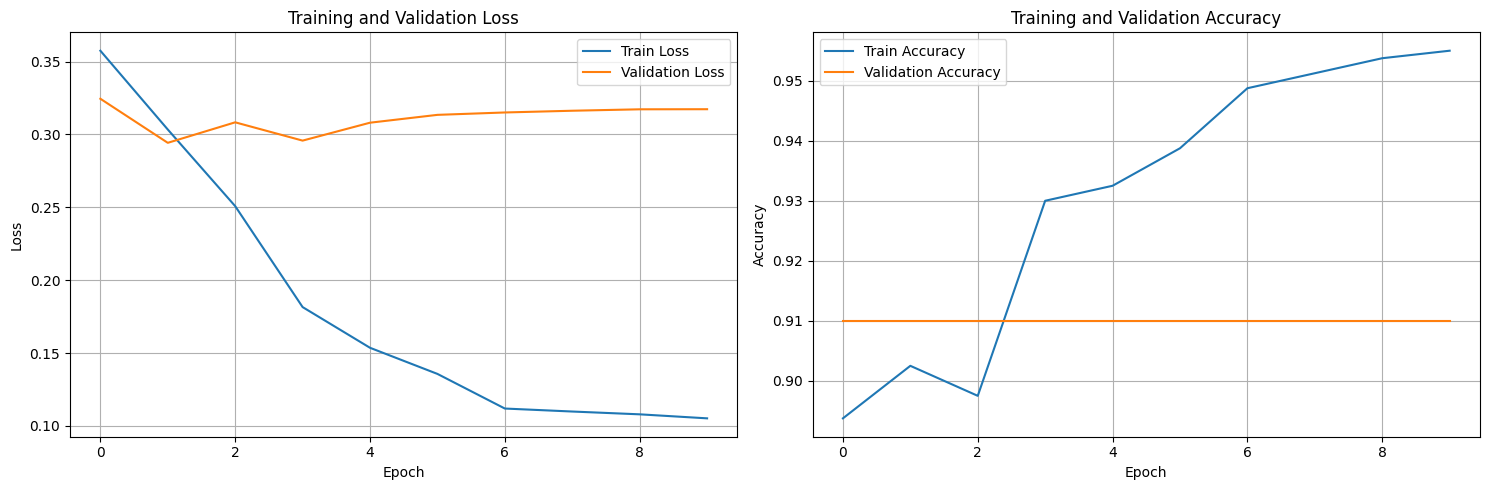

In [15]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [16]:
# Evaluation on Test Set

# Load best model
model.load_state_dict(torch.load('best_vivit_deepfake_model.pth'))
model.eval()

# Evaluate on test set
test_predictions = []
test_labels_list = []

print("Evaluating on test set...")
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(pixel_values)
        _, predicted = torch.max(outputs.logits.data, 1)

        test_predictions.extend(predicted.cpu().numpy())
        test_labels_list.extend(labels.cpu().numpy())

# Calculate metrics
test_accuracy = accuracy_score(test_labels_list, test_predictions)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels_list, test_predictions,
                          target_names=['Real', 'Fake']))

Evaluating on test set...


Testing: 100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


Test Accuracy: 0.9000

Classification Report:
              precision    recall  f1-score   support

        Real       0.00      0.00      0.00        10
        Fake       0.90      1.00      0.95        90

    accuracy                           0.90       100
   macro avg       0.45      0.50      0.47       100
weighted avg       0.81      0.90      0.85       100



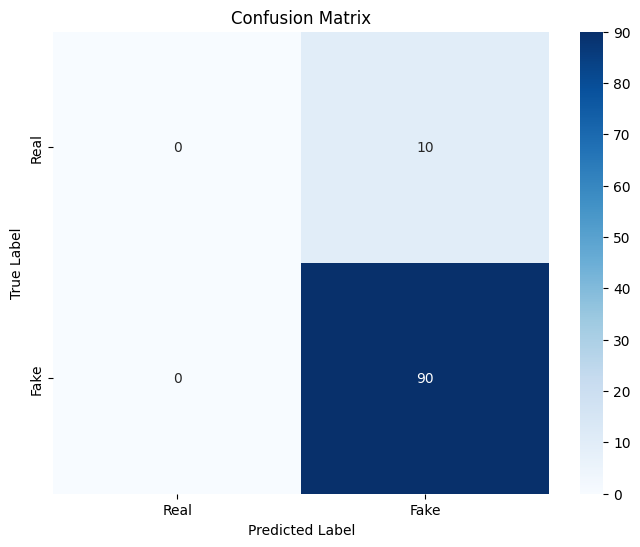

True Negatives: 0
False Positives: 10
False Negatives: 0
True Positives: 90
Precision: 0.9000
Recall: 1.0000
F1-Score: 0.9474


In [17]:
# Plot confusion matrix
cm = confusion_matrix(test_labels_list, test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print detailed metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

In [18]:
# Save Final Model and Results

from google.colab import drive
if not os.path.exists('/content/gdrive/MyDrive'):
    drive.mount('/content/gdrive')
else:
    print("Google Drive already mounted.")

gdrive_base_path = '/content/gdrive/MyDrive/deepfake_detection_results'
os.makedirs(gdrive_base_path, exist_ok=True)
print(f"Saving to Google Drive path: {gdrive_base_path}")

# Define full paths for saving
model_save_path = os.path.join(gdrive_base_path, 'vivit_deepfake_final_model.pth')
results_save_path = os.path.join(gdrive_base_path, 'deepfake_detection_results.json')

# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'config': model.config, # Ensure model.config exists and is serializable
    'test_accuracy': test_accuracy,
    'training_history': {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }
}, model_save_path)

# Save results to JSON
results = {
    'test_accuracy': float(test_accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.tolist(), # Convert numpy array to list for JSON
    'num_epochs': num_epochs,
    'learning_rate': learning_rate,
    'batch_size': batch_size,
    'dataset_size': len(all_videos) # Assuming 'all_videos' holds your dataset
}

with open(results_save_path, 'w') as f:
    json.dump(results, f, indent=2)

print("Model and results saved successfully to Google Drive!")
print(f"Final test accuracy: {test_accuracy:.4f}")

Mounted at /content/gdrive
Saving to Google Drive path: /content/gdrive/MyDrive/deepfake_detection_results
Model and results saved successfully to Google Drive!
Final test accuracy: 0.9000
